In [198]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Classification of hand-written digits

We start by downloading and extracting the MNIST data set.

In [199]:
# Dataset available at https://github.com/knamdar/data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())


# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all test images and labels into PyTorch tensors
# the training data will be loaded in batches during training
test_X, test_Y = extract(testset)

## The model

The input data $X$ are grayscale images of $28\times 28$ pixels. The first dimension will be the number of data points that are provided to the network. The input data is flattend into a matrix with $28 \times 28 = 784$ columns using `X.view(-1, 784)`, where each colum represents one pixel. We then apply first the linear transformation $X W + b$ and then the softmax function to obtain the class probabilities predicted by the model.

In [200]:
class Net(nn.Module):
    def __init__(self,U,filter_sizes,strides,paddings,pzero):
        super(Net, self).__init__()
        # Hidden units
        self.U1 = U[0]
        self.W1 = nn.Parameter(0.1 * torch.randn(self.U1, 1, filter_sizes[0], filter_sizes[0]))
        self.b1 = nn.Parameter(torch.ones(self.U1)/10)
        
        self.U2 = U[1]
        self.W2 = nn.Parameter(0.1 * torch.randn(self.U2, self.U1, filter_sizes[1], filter_sizes[1]))
        self.b2 = nn.Parameter(torch.ones(self.U2)/10)
        
        self.U3 = U[2]
        self.W3 = nn.Parameter(0.1 * torch.randn(self.U3, self.U2, filter_sizes[2], filter_sizes[2]))
        self.b3 = nn.Parameter(torch.ones(self.U3)/10)
        
        self.U4 = U[3]
        self.W4 = nn.Parameter(0.1 * torch.randn(7*7*self.U3, self.U4))
        self.b4 = nn.Parameter(torch.ones(self.U4)/10)
        
        self.dropout = nn.Dropout(p=pzero)
        
        # Last layer
        self.W5 = nn.Parameter(0.1 * torch.randn(self.U4, 10))
        self.b5 = nn.Parameter(torch.ones(10)/10)

    def forward(self, X):
        # flatten the data into a matrix with 28 x 28 = 784 columns
        # X = X.view(-1, 784)
        # Sigmoid hidden layer
        Q1 = F.relu(F.conv2d(X, self.W1, bias=self.b1, stride=strides[0], padding=paddings[0]))
        Q2 = F.relu(F.conv2d(Q1, self.W2, bias=self.b2, stride=strides[1], padding=paddings[1]))
        Q3 = F.relu(F.conv2d(Q2, self.W3, bias=self.b3, stride=strides[2], padding=paddings[2]))
        U3flat = 7*7*self.U3
        Q3flat = Q3.view(-1, U3flat)
        Q4 = F.relu(Q3flat.mm(self.W4) + self.b4)
        Q4dropout = self.dropout(Q4)
        # apply the softmax function <-- don't. Numerical instability
        # G = F.softmax(Q4.mm(self.W5) + self.b5, dim=1)
        # Return Logits instead
        Z = Q4dropout.mm(self.W5) + self.b5
        return Z #G

## The training

We define the cross-entropy for the predicted probabilities $G$ (10-dimensional vectors) and the labels $Y$ (integers between 0 and 9).

In [201]:
def crossentropy(G, Y):
    # convert labels to onehot encoding
    Y_onehot = torch.eye(10, device=device)[Y]

    return -(Y_onehot * G.log()).sum(dim = 1).mean()

The next lines evaluate the accuracy of the predictions.

In [202]:
def accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

We are ready to train the network.

In [215]:
# Configuration parameters
U = [6,12,24,200]
filter_sizes = [6,5,4]
strides = [1,2,2]
paddings = [2,2,1]
lr_max = 0.003
lr_min = 0.00001
conv_rate = 5000
pzero = 0.22
N = 50000

# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []

# initialize the neural network and move it to the GPU if needed
net = Net(U,filter_sizes,strides,paddings,pzero)
net.to(device)

# define the optimization algorithm
optimizer = optim.Adam(net.parameters(), lr=lr_max)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = N # total number of iterations
t = 0 # current iteration
done = False
net.train()
while not done:
    for (batch_X, batch_Y) in trainloader:
        
        lr_new = lr_min + (lr_max - lr_min)*np.exp(-t / conv_rate)
        for p in optimizer.param_groups:
            p['lr'] = lr_new
        
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = F.cross_entropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                net.eval()
                G = net(X)
                test_crossentropy.append(crossentropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)
                net.train()

            # print the iteration number and the accuracy of the predictions
            if t % (N/20) == 0:
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy  11.00% train cross-entropy  2.42  test accuracy  19.17% test cross-entropy   nan
Step  2500: train accuracy  99.00% train cross-entropy  0.04  test accuracy  98.94% test cross-entropy   nan
Step  5000: train accuracy  99.00% train cross-entropy  0.01  test accuracy  99.11% test cross-entropy   nan
Step  7500: train accuracy 100.00% train cross-entropy  0.00  test accuracy  99.11% test cross-entropy   nan
Step 10000: train accuracy 100.00% train cross-entropy  0.00  test accuracy  99.18% test cross-entropy   nan
Step 12500: train accuracy 100.00% train cross-entropy  0.00  test accuracy  99.15% test cross-entropy   nan
Step 15000: train accuracy 100.00% train cross-entropy  0.00  test accuracy  99.21% test cross-entropy   nan
Step 17500: train accuracy 100.00% train cross-entropy  0.00  test accuracy  99.21% test cross-entropy   nan
Step 20000: train accuracy 100.00% train cross-entropy  0.00  test accuracy  99.18% test cross-entropy   nan
Step 22500: train a

## The evaluation

The remaining code produces the plots needed to evaluate the training and predictions.

In [204]:
#n = 3
#f = open("fivelayers.txt", "a+")
#f.write(f'{net.U} | {100*sum(test_accuracy[-n:])/n:.1f}\n')
#f.close()

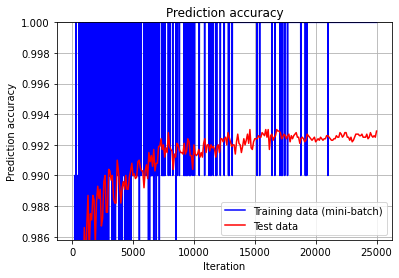

In [214]:
# plot the cross-entropy
# plt.plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
# plt.plot(test_iter, test_crossentropy, 'r-', label='Test data')
# plt.xlabel('Iteration')
# plt.ylabel('Cross-entropy')
# plt.ylim([0, min(test_crossentropy) * 3])
# plt.title('Cross-entropy')
# plt.grid(True)
# plt.legend(loc='best')
# plt.show()

# plot the accuracy
plt.plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_accuracy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Prediction accuracy')
plt.ylim([max(1 - (1 - test_accuracy[-1]) * 2, 0), 1])
plt.title('Prediction accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

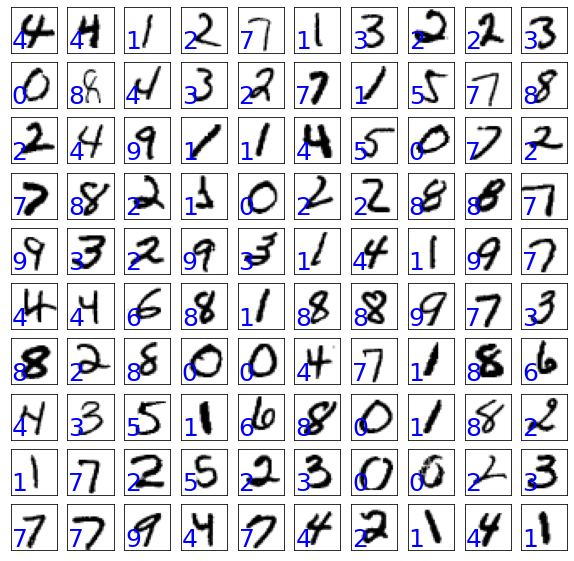

In [206]:
# evaluate the network on 100 random test images
with torch.no_grad():
    # obtain 100 random samples from the test data set
    random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)))
    
    # move data to the GPU if needed
    random_X, random_Y = random_X.to(device), random_Y.to(device)
    
    # compute the predictions for the sampled inputs
    random_G = net(random_X)
    random_Yhat = random_G.argmax(dim=1)

    # sort the predictions with the incorrect ones first
    indices_incorrect_first = (random_Yhat == random_Y).float().argsort()

# plot the images
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, index in enumerate(indices_incorrect_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    
    # plot the image
    plt.imshow(random_X[index, :, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)
    
    # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
    color = 'blue' if random_Yhat[index] == random_Y[index] else 'red'
    plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)
        
plt.show()